# Preprocess CNAs from Firehose
In this notebook, I want to preprocess all the CNA data that Hotnet2 used for their identification of significant submodules. I already downloaded the the output from GISTIC2 from Firehose, using the firehose_get tool with:

`./firehose_get -tasks gistic analysis latest`

This was cumbersome and now I have one folder, containing gzipped folders for each cancer type.
The result are two matrices that are written to disk.

* The first matrix has shape $\big(genes \times cancertypes\big) \in \mathrm{R}$ and contains the mean number of samples for which the gene was affected.
* The second matrix $\big(genes \times samples\big) \in \{0, 1\}$ contains a $1$ if the gene in the sample is affected by a CNA and $0$ otherwise.

In [1]:
import pandas as pd
import numpy as np
import gzip
import os, sys
import tarfile

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# test
import mygene

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Parameters for the Script
The parameters have the following meaning:
* `GISTIC_THRESHOLD`: GISTIC2 writes for each sample if a CNA is affecting the gene with a high probability (2) and medium probability (1) or not (0). Setting the threshold to 1 means that you also use CNAs with medium probability. Setting it to 2 means that you use only high confidence CNAs.
* `REMOVE_INCONSISTENT_CNAS`: Don't consider CNAs that are not at least present in 75% of samples. This was done in the Hotnet2 preprocessing.
* `ANALYSIS_DATE`: Firehose has multiple analyses done and they can be downloaded at different time points. Currently (April 2018), `latest` in the firehose_get command refers to 20160128.
* `ROOT_DIR`: The directory in which the firehose data can be found.
* `CANCER_TYPES`: The cancer types you are interested in as a list.

In [3]:
GISTIC_THRESHOLD = 2
REMOVE_INCONSISTENT_CNAS = False
ANALYSIS_DATE = '20160128' # latest
ROOT_DIR = '../../data/pancancer/firehose/analyses__2016_01_28/' # where the firehose download is located
# CANCER_TYPES describes the cancer types, I am interested in
CANCER_TYPES = ['BRCA', 'LUAD', 'UCEC', 'KIRC', 'HNSC', 'THCA', 'LUSC', 'PRAD', 'COAD', 'STAD', 'BLCA', 'LIHC', 'CESC', 'KIRP', 'ESCA', 'READ']

In [4]:
def get_target_genes(fname):
    """Extract all genes per CNA from file
    
    This method extracts the target genes for all CNAs (either amps or dels) from GISTIC2 output files.
    Parameters:
    ---------
    fname:            The file to read from
    
    Returns:
    A dictionary with the descriptors of the CNAs as keys. The values are lists of target genes.
    """
    cna_genes_df = pd.read_csv(fname, sep='\t')
    relevant_cols = cna_genes_df.iloc[3:, 1:].dropna(how='all', axis=1)
    genes_per_cna = {}
    for col in relevant_cols.columns:
        genes_per_cna[col] = [i.split('|')[0].lstrip('[').rstrip(']') for i in relevant_cols[col].dropna().tolist()]
    return genes_per_cna

def get_genes_from_target_dict(genes_per_cna):
    return list(set({x for v in genes_per_cna.values() for x in v}))

def get_samples(lesions):
    return lesions.iloc[:, 9:].dropna(how='all', axis=1).columns


def get_target_genes_from_gistic(lesions, amps, dels):
    # first, get the target genes for all CNAs
    amp_targets = get_target_genes(amps)
    del_targets = get_target_genes(dels)
    all_targets = {**amp_targets, **del_targets} # no duplicate keys possible
    list_of_targets = get_genes_from_target_dict(all_targets)
    
    # Next, get the sample IDs
    all_lesions = pd.read_csv(lesions, sep='\t')
    if REMOVE_INCONSISTENT_CNAS:
        mean_cnas = (all_lesions.iloc[:, 9:] >= GISTIC_THRESHOLD).mean(axis=1)
        all_lesions = all_lesions[mean_cnas >= .75]
    samples = get_samples(all_lesions)
    
    # construct target matrix (genes x samples; 1 indicates that sample has CNA affecting the gene)
    target_gene_matrix = pd.DataFrame(0, index=list_of_targets, columns=samples)
    all_lesions = all_lesions[~all_lesions['Unique Name'].str.contains("CN values")]
    for sample in samples:
        cnas = all_lesions[all_lesions.loc[:, sample] >= GISTIC_THRESHOLD].Descriptor
        genes_subset = dict((k, all_targets[k.strip()]) for k in cnas)
        target_genes_for_sample = get_genes_from_target_dict(genes_subset)
        target_gene_matrix.loc[target_gene_matrix.index.isin(target_genes_for_sample), sample] = 1
    return target_gene_matrix
    

def get_target_genes_per_sample(root_dir, cancer_type, analysis_date):
    analysis_dir = 'gdac.broadinstitute.org_{}-T{}.CopyNumber_Gistic2.Level_4.{}00.0.0.tar.gz'
    p = os.path.join(root_dir, analysis_dir.format(cancer_type, 'B' if cancer_type is 'LAML' else 'P', analysis_date))
    if os.path.isfile(p):
        #print ("Extracting target genes from {}".format(p))
        dir_prefix = analysis_dir.rstrip(".tar.gz").format(cancer_type,
                                                           'B' if cancer_type is 'LAML' else 'P',
                                                           analysis_date)
        tar = tarfile.open(p, "r:gz")
        lesions_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'all_lesions.conf_99.txt')))
        amp_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'amp_genes.conf_99.txt')))
        del_tar = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'del_genes.conf_99.txt')))
        return get_target_genes_from_gistic(lesions_tar, amp_tar, del_tar)
    else:
        print ("Error. Path {} does not exist".format(p))

def extract_targets_all_cancers(root_dir, analysis_date, cancer_types):
    result_samples = None
    result_cancertype = None
    for cancer_type in cancer_types:
        sample_matrix = get_target_genes_per_sample(os.path.join(root_dir, cancer_type, analysis_date),
                                                    cancer_type, analysis_date)
        mean_matrix = pd.DataFrame(sample_matrix.mean(axis=1), columns=[cancer_type])
        print ("For Cancer {}:".format(cancer_type))
        print ("Found {} genes for {} samples with avg {} mutated genes".format(sample_matrix.shape[0],
                                                                                sample_matrix.shape[1],
                                                                                sample_matrix.sum().sum() / sample_matrix.shape[1]))
        print ("{0:.2f}% mutations across all samples".format((sample_matrix.sum().sum() / np.prod(sample_matrix.shape))*100))
        print ("-----------------------------------------")
        if result_samples is None:
            result_samples = sample_matrix
            result_cancertype = mean_matrix
            
        else:
            result_samples = result_samples.append(sample_matrix)
            result_cancertype = result_cancertype.append(mean_matrix)
            
    result_samples.fillna(0, inplace=True)
    result_cancertype.fillna(0, inplace=True)
    result_samples = result_samples.groupby(result_samples.index).sum()
    result_cancertype = result_cancertype.groupby(result_cancertype.index).sum()
    return result_samples, result_cancertype

def extract_threshold_matrices(root_dir, analysis_date, cancer_types):
    result_samples = None
    result_cancertype = None
    for cancer_type in cancer_types:
        analysis_dir = 'gdac.broadinstitute.org_{}-T{}.CopyNumber_Gistic2.Level_4.{}00.0.0.tar.gz'
        base_dir = os.path.join(root_dir, cancer_type, analysis_date)
        p = os.path.join(base_dir, analysis_dir.format(cancer_type, 'B' if cancer_type is 'LAML' else 'P', analysis_date))
        dir_prefix = analysis_dir.rstrip(".tar.gz").format(cancer_type,
                                                           'B' if cancer_type is 'LAML' else 'P',
                                                           analysis_date)
        with tarfile.open(p, "r:gz") as tar:
            sample_path = tar.extractfile(tar.getmember(os.path.join(dir_prefix, 'all_thresholded.by_genes.txt')))
            sample_matrix = pd.read_csv(sample_path, sep='\t')
        sample_matrix.drop(['Locus ID', 'Cytoband'], axis=1, inplace=True)
        sample_matrix.set_index('Gene Symbol', inplace=True)
        if GISTIC_THRESHOLD == 2:
            sample_matrix.replace(1, 0, inplace=True)
            sample_matrix.replace(-1, 0, inplace=True)
            sample_matrix.replace(2, 1, inplace=True)
            sample_matrix.replace(-2, -1, inplace=True)
        mean_matrix = pd.DataFrame(sample_matrix.mean(axis=1), columns=[cancer_type])
        print ("For Cancer {}:".format(cancer_type))
        print ("Found {} genes for {} samples with avg {} mutated genes".format(sample_matrix.shape[0],
                                                                                sample_matrix.shape[1],
                                                                                sample_matrix.sum().sum() / sample_matrix.shape[1]))
        print ("{0:.2f}% mutations across all samples".format((sample_matrix.sum().sum() / np.prod(sample_matrix.shape))*100))
        print ("-----------------------------------------")
        if result_samples is None:
            result_samples = sample_matrix
            result_cancertype = mean_matrix
            
        else:
            result_samples = result_samples.append(sample_matrix)
            result_cancertype = result_cancertype.append(mean_matrix)
            
    result_samples.fillna(0, inplace=True)
    result_cancertype.fillna(0, inplace=True)
    result_samples = result_samples.groupby(result_samples.index).sum()
    result_cancertype = result_cancertype.groupby(result_cancertype.index).sum()
    return result_samples, result_cancertype

In [5]:
#cna_sample_matrix, cna_mean_matrix = extract_targets_all_cancers(ROOT_DIR, ANALYSIS_DATE, CANCER_TYPES)
cna_sample_matrix, cna_mean_matrix = extract_threshold_matrices(ROOT_DIR, ANALYSIS_DATE, CANCER_TYPES)

For Cancer BRCA:
Found 24776 genes for 1080 samples with avg 441.6148148148148 mutated genes
1.78% mutations across all samples
-----------------------------------------
For Cancer LUAD:
Found 24776 genes for 516 samples with avg 273.9011627906977 mutated genes
1.11% mutations across all samples
-----------------------------------------
For Cancer UCEC:
Found 24776 genes for 539 samples with avg 284.39332096474953 mutated genes
1.15% mutations across all samples
-----------------------------------------
For Cancer KIRC:
Found 24776 genes for 528 samples with avg 46.509469696969695 mutated genes
0.19% mutations across all samples
-----------------------------------------
For Cancer HNSC:
Found 24776 genes for 522 samples with avg 235.0344827586207 mutated genes
0.95% mutations across all samples
-----------------------------------------
For Cancer THCA:
Found 24776 genes for 499 samples with avg 3.2224448897795592 mutated genes
0.01% mutations across all samples
------------------------

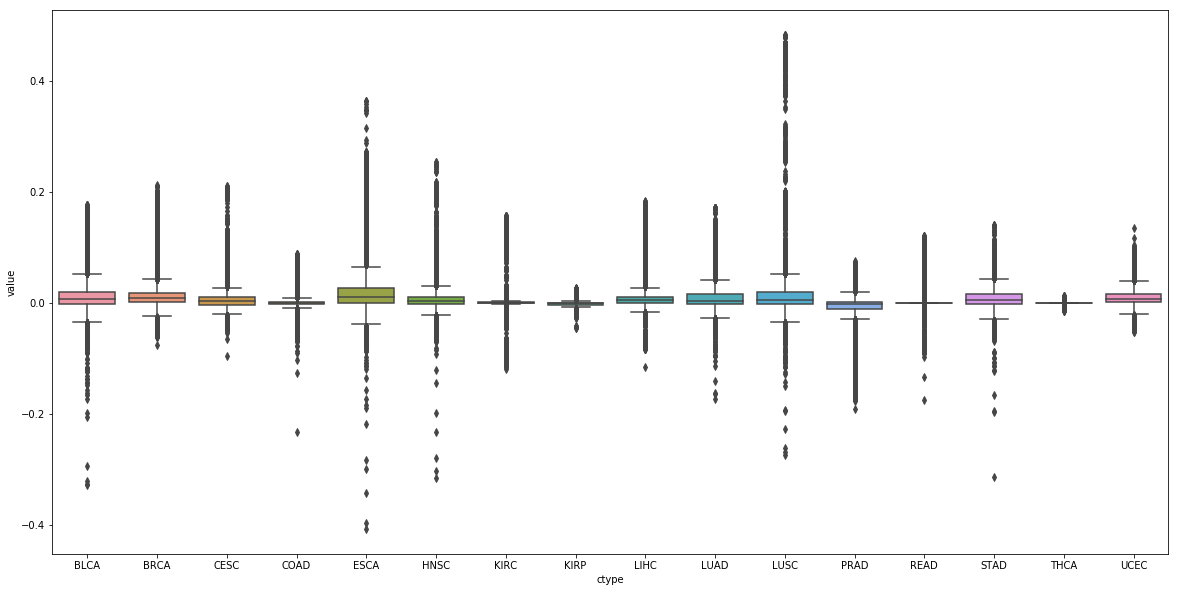

In [6]:
#ax = cna_mean_matrix.plot(kind='box', figsize=(16, 10), title='CNAs across different cancer types')
#ax.set_ylabel('Frequency of genes affected by CNAs')
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x='ctype', y='value', data=pd.melt(cna_mean_matrix, var_name='ctype'))

In [9]:
cna_mean_matrix.to_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_meancancertypes_{}.tsv'.format(ANALYSIS_DATE), sep='\t')
cna_sample_matrix_int = cna_sample_matrix.astype(np.uint8) # saves space and time
cna_sample_matrix_int.to_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_sample_{}.tsv'.format(ANALYSIS_DATE))

In [89]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_ensembl_ids(list_of_gene_symbols):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_gene_symbols,
                       scopes='symbol, refseq, uniprot',
                       fields='ensembl.gene',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        if 'ensembl' in x:
            ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
            symbol = x['query']
            return [symbol, ens_id]
        else:
            return [x['query'], None]

    ens_ids = [get_name_and_id(x) for x in res['out']]
    
    node_names = pd.DataFrame(ens_ids, columns=['Symbol', 'Ensembl_ID']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    node_names.drop_duplicates(inplace=True)
    return node_names

In [86]:
test = pd.read_csv('../../data/pancancer/TCGA/mutation/CNA/BLCA.focal_score_by_genes.txt', sep='\t')
test.drop(['Gene ID', 'Cytoband'], axis=1, inplace=True)
test.set_index('Gene Symbol', inplace=True)
new_idx = [i[0] for i in test.index.str.split('.')]
test['ID'] = new_idx
test.set_index('ID', inplace=True)
symbols = get_gene_symbols(test.index)
test_names = test.join(symbols).set_index('Symbol')
test_names = test_names.loc[~test_names.index.duplicated(keep='first')]
test.head()

,68cef882-5ac4-4c7b-9d99-3bc3bc15d0fe,d59d48ca-16e5-46c0-80e8-6d1214acd156,5c618903-3b51-475b-837e-a56680a7cf80,1d160de2-9c94-4172-9934-aad4322a5141,00e2a4bb-6ef0-4e36-88ba-d0cb858b55e6,75f64631-fcf0-4dad-9d25-c400126bcecb,321f7819-40df-4d1a-a2dd-739bedaf21e0,98bf8cd9-4d14-46d2-b20a-d2c7533e4391,6588b3af-1812-4203-aa6d-55c73d05b9ee,02d3b1e9-adaa-4722-8579-b69999e7ff37,...,2deb5157-dba6-43e3-b231-c13af5a1988c,a51cc246-1b2e-4639-8966-de050a21fdd8,12cc440c-3723-4c92-b989-7c35cd03cbe4,57f8cf7e-216b-470a-9b60-9c505a262a3d,f7edcec3-b0fa-4eec-9b20-4c549b4075c1,cd1e5b56-4216-44d6-9f67-805ff88c2155,074c98bd-ae0c-4f93-a18a-024faecfe555,6ff53711-efbf-4db9-95f1-71f343af0aae,6069177a-b833-4121-9622-6435164b1413,ead101ca-8ffc-46b1-93db-0022fb0d88a7
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ENSG00000008128.21,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,-1,0,0,1,0,0,0
ENSG00000008130.14,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,-1,0,0,1,0,0,0
ENSG00000067606.14,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,-1,0,0,1,0,0,0
ENSG00000078369.16,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,-1,0,0,1,0,0,0
ENSG00000078808.15,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,-1,0,0,1,0,0,0


In [239]:
cna_blca_matrix = cna_sample_matrix.loc[:, cna_sample_matrix.columns.isin(blca_df_reindexed.columns)]

In [284]:
p = '../../data/pancancer/firehose/analyses__2016_01_28/BLCA/20160128/gdac.broadinstitute.org_BLCA-TP.CopyNumber_Gistic2.Level_4.2016012800.0.0.tar.gz'
prefix = 'gdac.broadinstitute.org_BLCA-TP.CopyNumber_Gistic2.Level_4.{}00.0.0'.format(ANALYSIS_DATE)
print (os.path.join(prefix, 'all_thresholded.by_genes.txt'))
tar = tarfile.open(p, "r:gz")
blca_matrix = tar.extractfile(tar.getmember(os.path.join(prefix, 'all_thresholded.by_genes.txt')))
tar.close()

gdac.broadinstitute.org_BLCA-TP.CopyNumber_Gistic2.Level_4.2016012800.0.0/all_thresholded.by_genes.txt


In [80]:
blca_df = pd.read_csv(blca_matrix, sep='\t')
blca_df.drop(['Locus ID', 'Cytoband'], axis=1, inplace=True)
blca_df.set_index('Gene Symbol', inplace=True)
blca_df.head()

,TCGA-2F-A9KO-01A-11D-A38F-01,TCGA-2F-A9KP-01A-11D-A38F-01,TCGA-2F-A9KQ-01A-11D-A38F-01,TCGA-2F-A9KR-01A-11D-A38F-01,TCGA-2F-A9KT-01A-11D-A38F-01,TCGA-2F-A9KW-01A-11D-A38F-01,TCGA-4Z-AA7M-01A-11D-A390-01,TCGA-4Z-AA7N-01A-11D-A390-01,TCGA-4Z-AA7O-01A-31D-A390-01,TCGA-4Z-AA7Q-01A-11D-A390-01,...,TCGA-ZF-AA4X-01A-11D-A38F-01,TCGA-ZF-AA51-01A-21D-A390-01,TCGA-ZF-AA52-01A-12D-A390-01,TCGA-ZF-AA53-01A-11D-A390-01,TCGA-ZF-AA54-01A-11D-A390-01,TCGA-ZF-AA56-01A-31D-A390-01,TCGA-ZF-AA58-01A-12D-A42D-01,TCGA-ZF-AA5H-01A-11D-A390-01,TCGA-ZF-AA5N-01A-11D-A42D-01,TCGA-ZF-AA5P-01A-11D-A390-01
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ACAP3,-1,2,0,0,0,-2,0,0,0,0,...,-1,1,1,1,-1,0,0,1,0,0
ACTRT2,-1,2,0,0,0,-2,0,0,0,0,...,-1,1,1,1,-1,0,0,1,0,0
AGRN,-1,2,0,0,0,-2,0,0,0,0,...,-1,1,1,1,-1,0,0,1,0,0
ANKRD65,-1,2,0,0,0,-2,0,0,0,0,...,-1,1,1,1,-1,0,0,1,0,0
ATAD3A,-1,2,0,0,0,-2,0,0,0,0,...,-1,1,1,1,-1,0,0,1,0,0


In [259]:
blca_df_reindexed = blca_df.reindex(cna_blca_matrix.index).dropna(axis=0)
blca_df_reindexed = blca_df_reindexed.loc[~blca_df_reindexed.index.duplicated(keep='first')]
cna_blca_matrix_reindexed = cna_blca_matrix.reindex(blca_df_reindexed.index)
cna_blca_matrix_reindexed = cna_blca_matrix_reindexed.loc[~cna_blca_matrix_reindexed.index.duplicated(keep='first')]
#test_reindexed = test_names.reindex(blca_df_reindexed.index)

In [241]:
(blca_df_reindexed < -1).mean(axis=1).sum() + (blca_df > 1).mean(axis=1).sum(), (test < 0).sum(axis=1).sum() + (test > 0).sum(axis=1).sum()

(598.7230392155773, 801612)

In [242]:
(blca_df_reindexed > 1).sum(axis=1).sum() + (blca_df_reindexed < -1).sum(axis=1).sum()

224629

In [243]:
(test_reindexed > 0).mean(axis=1).sum() + (test_reindexed < 0).mean(axis=1).sum()

1742.7036144578294

In [254]:
blca_df_reindexed.shape, cna_blca_matrix_reindexed.shape

((21789, 408), 32338.0)

In [248]:
for col in blca_df_reindexed.columns[:1]:
    print (col)
    level4_values = blca_df_reindexed.loc[:, col]
    level4_values.replace(1, 0, inplace=True)
    level4_values.replace(-1, 0, inplace=True)
    level4_values.replace(2, 1, inplace=True)
    level4_values.replace(-2, -1, inplace=True)
    our_values = cna_blca_matrix_reindexed.loc[:, col]
    print (our_values.min(), level4_values.min())
    print (our_values[np.logical_xor((level4_values != 0), (our_values != 0))].shape)
    print (level4_values[level4_values.index == 'AASDHPPT'])
    print (our_values[our_values.index == 'AASDHPPT'])

TCGA-2F-A9KO-01A-11D-A38F-01
0.0 0.0
(0,)
AASDHPPT    0.0
Name: TCGA-2F-A9KO-01A-11D-A38F-01, dtype: float64
AASDHPPT    0.0
Name: TCGA-2F-A9KO-01A-11D-A38F-01, dtype: float64


In [255]:
blca_df_reindexed.loc[:, 'TCGA-2F-A9KO-01A-11D-A38F-01'].sum(), cna_blca_matrix_reindexed.loc[:, 'TCGA-2F-A9KO-01A-11D-A38F-01'].sum()

(0.0, 0.0)

In [261]:
(np.abs(blca_df_reindexed.loc[:, 'TCGA-2F-A9KO-01A-11D-A38F-01']) == 2).sum(), (cna_blca_matrix_reindexed.loc[:, 'TCGA-2F-A9KO-01A-11D-A38F-01'] == 1).sum()

(146, 0)

In [270]:
blca_df_reindexed.sum().max()

10742.0